# Setup

In [444]:
%matplotlib inline

In [450]:
import math
from matplotlib import pyplot as plt
from fastai.torch_core import show_image

def show_images(
    images, 
    ncols=None, 
    nrows=None, 
    cmap="coolwarm", 
    vmin=None, 
    vmax=None, 
    vrange=0.5, 
    figsize=None, 
    **kwargs
):
    ncols = ncols or len(images)
    nrows = math.ceil(len(images) / ncols)
    
    abs_max = max(image.abs().max() for image in images)
    vmin = vmin if vmin is not None else -abs_max * vrange
    vmax = vmax if vmax is not None else +abs_max * vrange

    figsize = figsize or (ncols, nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    
    for image, ax in zip(images, axs.flat):
        show_image(image, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)

In [446]:
def param_count(module):
    return sum(param.numel() for param in module.parameters())

# Vision models

Intro to image recognition with neural networks

## Plan

1. Machine Learning
2. MNIST dataset
3. Preparing data for training
4. Evaluating a model
5. Testing various models

Previously we've focused on how neural networks work at the low level and glossed over the overall machine learning process. In this talk we'll go over the whole process of building a model:

- Downloading and exploring data
- Preparing training and validation sets
- Picking metrics to judge our models
- Experiments with various models
- Tweaks to make our models train faster

We will try to create a model for handwritten digit recognition using the very popular [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).

> **Note:**
> For some reason the original link to MNIST dataset https://yann.lecun.com/exdb/mnist/ is asking for authentication, so I've linked to the Wikipedia article instead

Links:
- https://yann.lecun.com/exdb/mnist/

## Machine Learning

Approach to solving tasks by learning an algorithm from examples.

> Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.
>
> [Arthur L. Samuel, Artificial Intelligence: A Frontier of Automation, 1962](https://journals.sagepub.com/doi/abs/10.1177/000271626234000103)

Usually when we want the computer to do something we need to explain in detail what we want it to do. Computers are powerful, but really dumb, they will only do what we ask them to do... and that's fine for a lot of problems. However, there are problems we can't easily explain to a computer, because we don't really know what needs to be done to recognize a dog in an image.

Arthur Samuel, an IBM researcher, proposed a different way of explaining tasks to computers, by providing examples of data and letting the computer figure the algorithm out.

Links:
- https://nbviewer.org/github/fastai/fastbook/blob/master/01_intro.ipynb
- https://en.wikipedia.org/wiki/Machine_learning
- https://en.wikipedia.org/wiki/Arthur_Samuel_(computer_scientist)

Machine learning loop

![Machine learning loop](./images/machine_learning_loop.png)

First off we need some examples of data that will be passed to our model, in the case of our husky/wolf classifier from the previous talk that would be the set of pictures of huskies and wolves that we downloaded.

Depending on whether we know what these examples represent, what the expected outputs are, we split machine learning into:

- supervised learning
- unsupervised learning

We will focus on supervised learning for now and assume we have labeled examples. Once we have inputs and labels we need a way to measure the performance of any model we are going to try. Finally we can create a parametric model and optimize the parameters to maximize the performance on our examples.

...which for neural networks becomes

![Neural network training loop](./images/neural_network_training_loop.png)

## MNIST dataset

A dataset of grayscale images of handwritten digits. `fastai` has utilities for downloading various well-known datasets, including MNIST.

In [4]:
from pathlib import Path
from fastai.data.external import untar_data, URLs

data_path = (Path("..") / "data").resolve()
mnist_path = untar_data(url=URLs.MNIST, data=data_path)
mnist_path

Path('/home/dev/workspace/data/mnist_png')

Links:
- https://docs.fast.ai/data.external.html

Let's check what was downloaded

In [5]:
!tree -L 2 -sh --du {mnist_path}

/home/dev/workspace/data/mnist_png
├── [154K]  testing
│   ├── [ 15K]  0
│   ├── [ 17K]  1
│   ├── [ 16K]  2
│   ├── [ 16K]  3
│   ├── [ 15K]  4
│   ├── [ 14K]  5
│   ├── [ 15K]  6
│   ├── [ 16K]  7
│   ├── [ 15K]  8
│   └── [ 16K]  9
└── [1.0M]  training
    ├── [102K]  0
    ├── [116K]  1
    ├── [103K]  2
    ├── [106K]  3
    ├── [101K]  4
    ├── [ 93K]  5
    ├── [102K]  6
    ├── [108K]  7
    ├── [101K]  8
    └── [102K]  9

 1.2M used in 22 directories, 0 files


In [6]:
list((mnist_path / "training" / "5").iterdir())[:5]

[Path('/home/dev/workspace/data/mnist_png/training/5/19858.png'),
 Path('/home/dev/workspace/data/mnist_png/training/5/14183.png'),
 Path('/home/dev/workspace/data/mnist_png/training/5/13532.png'),
 Path('/home/dev/workspace/data/mnist_png/training/5/41278.png'),
 Path('/home/dev/workspace/data/mnist_png/training/5/20428.png')]

We have 2 directories `training` and `testing`, each of which has 10 directories, 1 for each digit. Each of these directories in turn contain 28x28px grayscale images of handwritten digits. We can use the Python Imaging Library to view these images.

In [7]:
from PIL import Image

Image.open(mnist_path / "training" / "5" / "19858.png")

## Overfitting

- Model that works great, but only on its training set
- One of the biggest problem in ML
- A model should learn general concepts
- Complex models have more capacity to overfit

So what's up with these `training` and `testing` directories? We want our model to learn from our examples so that it can be applied to new data in future. For example we want to show it photos of wolves and huskies, train it and then use it to classify new photos. However, during training our model will look for the easiest way to achieve its goal. If we gave it enough parameters to play with it could memorize our training set and be 100% accurate on it, while being completely useless in the real world.

This is called overfitting and it doesn't have to be as extreme. In general it means our model is doing better on the training samples than on data it has never seen. This is probably the biggest common problem in ML and we have to take care to avoid it.

First of all we need to be able to detect overfitting and so we split our labeled data into at least 2 sets: training and validation. Training set is only used for training and validation set is used to evaluate our model's performance on data it has never seen. This way we can compare metrics of our model on these sets and if they are considerably worse on the validation set our model might be overfitting.

The easiest way to split the data is random sampling, e.g. select random 20% of your data and mark that as a validation set and leave the rest for training. However, there's a good chance this won't work depending on the task:

- if we are predicting future stock prices, we should ensure that the validation set contains dates after the training set
- if we are classifying facial expressions, we might want to ensure the validation set contains pictures of different people than the training set

MNIST dataset used to be used for comparing/benchmarking classifiers and so it provides ready to use training and validation (`testing`) sets, so we don't have to split the data ourselves. That said, if we had to, we should make sure that the validation set contains digits written by different people than the training set.

## DataLoader

Enough theory, let's load our training and validation sets. `pytorch` expects that datasets are defined using 2 classes:

- `Dataset` - provides an iterator that returns pairs of raw inputs and labels
- `DataLoader` - loads inputs and labels from a `DataSet` transforms them into `pytorch` `Tensor`s and returns an iterator of evenly sized batches, so we can train a model one batch at a time

`fastai` builds on top of that and provides the `DataBlock` class, which given an explanation of what our inputs and labels are, creates training and validation `Dataset`s and `DataLoader`s with sensible defaults and common transforms. To specify the shape of inputs and labels `fastai` provides various `Block` classes, we'll use:

- `ImageBlock` - for our input images
- `CategoryBlock` - for digit labels

In [8]:
from fastai.data.all import DataBlock, CategoryBlock, FuncSplitter
from fastai.vision.all import ImageBlock, PILImageBW

mnist_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    n_inp=1,
    get_items=lambda data_path: list(data_path.glob("*/*/*.png")),
    get_y=lambda image_path: image_path.parent.name,
    splitter=FuncSplitter(lambda image_path: image_path.parent.parent.name == "testing"),
)

Now that we've explained to `fastai` how our dataset looks like...

- `blocks` defines what kinds of data we have
- `n_inp` tells how many inputs we have, the rest will be treated as labels
- `get_items` describes how to get a list of all our images, provided a base path to our dataset
- `get_y` defines how to infer labels from image paths
- `spliter` defines how to split our images into training and validation sets

...we can ask it to create training and validation `DataLoader`s and explore how our samples look like

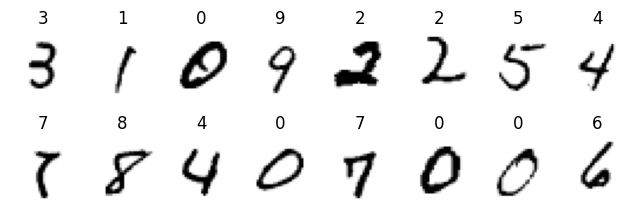

In [9]:
mnist_loaders = mnist_block.dataloaders(mnist_path, bs=64)
mnist_loaders.train.show_batch(max_n=16, ncols=8, figsize=(8, 2.5))

In [10]:
x, y = mnist_loaders.train.one_batch()
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

When creating a `DataLoader` we can specify a batch size `bs`, it defaults to `64`. We process data in batches, so that we don't have to hold the entire dataset in memory. For MNIST it's not that important, we could probably fit the entire set in memory without problems, but in general when working with bigger sets with more complex data we would quickly run out.

`DataBlock.dataloaders()` creates both training and validation loaders, available under `.train` and `.valid` respectively. `fastai` `DataLoader`s also provide the `show_batch()` method to quickly inspect the data based on the `blocks` we passed to the `DataBlock`.

Finally we can see that a batch contains 2 tensors each with 64 rows, which is our batch size. 

The first tensor contains our image data, each image is 28x28 pixels and since they are grayscale we also have `1` for the number of color channels. If we worked with color, we would have `3` (RGB) channels.

The second tensor contains our labels, not much to see here for now.

## Baseline

Before we start experimenting with various networks let's prepare a quick baseline for performance we'd like to beat. We can make a simple classifier that will compare an image to the average image of each digit and return the digit that's closest, e.g. using mean squared error of pixel values.

So let's start with calculating images of average digits.

In [11]:
import torch

def calc_mean_digits():
    device = mnist_loaders.device
    sums = torch.zeros(10, 1, 28, 28).to(device)
    counts = torch.zeros(10).to(device)
    
    for x, y in mnist_loaders.train:
        for category in range(10):
            sums[category] += x[y == category].sum(dim=0)
            counts[category] += (y == category).sum()
    
    return sums / counts.view(10, 1, 1, 1)

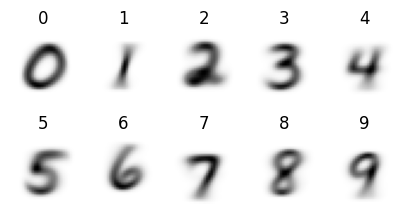

In [12]:
mean_digits = calc_mean_digits()
mnist_loaders.show_batch((mean_digits, range(10)), max_n=10, ncols=5, figsize=(5, 2.5))

Now we can build a baseline model that will compare inputs to the means and pick the digit which was closest.

In [13]:
from fastai.torch_core import TensorCategory

def baseline(x):
    distances = ((x - mean_digits.view(1, 10, 28, 28)) ** 2).mean(dim=(2, 3))
    _, y = distances.min(dim=1)
    return TensorCategory(y)

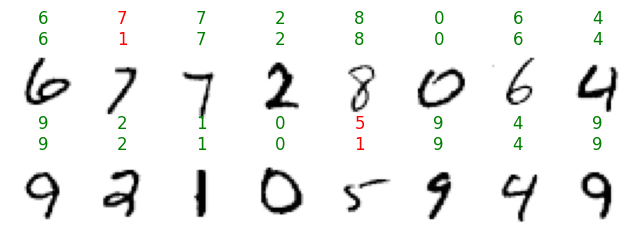

In [14]:
x, y = mnist_loaders.train.one_batch()
mnist_loaders.show_results((x, y), baseline(x), max_n=16, ncols=8, figsize=(8, 2.5))

It seems to be working pretty well, let's calculate the accuracy over both the training and validation sets.

In [15]:
def model_accuracy(model, loader):
    correct = sum((y == model(x)).sum() for x, y in loader).item()
    total = len(loader.dataset)
    return correct / total

train_accuracy = model_accuracy(baseline, mnist_loaders.train)
valid_accuracy = model_accuracy(baseline, mnist_loaders.valid)
train_accuracy, valid_accuracy

(0.8074166666666667, 0.8204)

Now we know that whatever model we choose, it has to have at least 82% accuracy, otherwise we might as well use our baseline model. 

## Regression

Now that we have a baseline we can start experimenting with various models. We have a 28x28 image as input and 1 number (the digit) as the output, so it's tempting to go with a model like:

In [16]:
from torch import nn

linear_regression = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 1),
)

`Flatten` reshapes the input so instead of being `28x28` it's just a vector of length `28 * 28`.

`Linear` creates a linear layer with random weights and biases `wx + b`, just like we created from scratch in the previous talk. Its arguments are numbers of inputs and outputs.

Finally `Sequential` just combines layers, so that first we `Flatten` our images and then pass it through the `Linear` layer.

The output of our network will be a single floating-point number, which we will round to the closest integer later. We could round it as part of the network, but that would result in our loss function being mostly flat with zero gradients. That's because changing parameters might result in the exact same output and as such, same loss as before the change, so gradient descent would not work.

Predicting a continuous value is called regression and so I've named our first network the `linear_regression` model. Predicting a category is called classification and we'll get to that later.

In [17]:
from fastai.learner import Learner
from fastai.losses import MSELossFlat

def mnist_regression_learner(model):
    def accuracy(pred, target):
        return (pred.round() == target).float().mean()
    
    return Learner(
        dls=mnist_loaders,
        model=model,
        loss_func=MSELossFlat(),
        metrics=[accuracy]
    )

To train a network with `fastai` we use the `Learner` class, it has a bunch of different parameters, but the most important are:

- `dls` - our `DataLoaders` instance, which will provide training and validation data
- `model` - the model we want to train
- `loss_func` - loss function we want to minimize, for regression mean squared error is a safe choice
- `metrics` - additional metrics we want to measure on the validation set while training

Once we've instantiated a `Learner`, we can start training using `fit` or `fit_one_cycle` methods. I won't go into the differences for now, but `fit_one_cycle` is faster 😉. We have to give it the number of epochs (how many times we want to repeat training over the full training set) and the learning rate.

The `Learner` class provides a `lr_find()` method, which tries a bunch of learning rates and suggests one for us, so let's try that first.

SuggestedLRs(valley=0.005248074419796467)

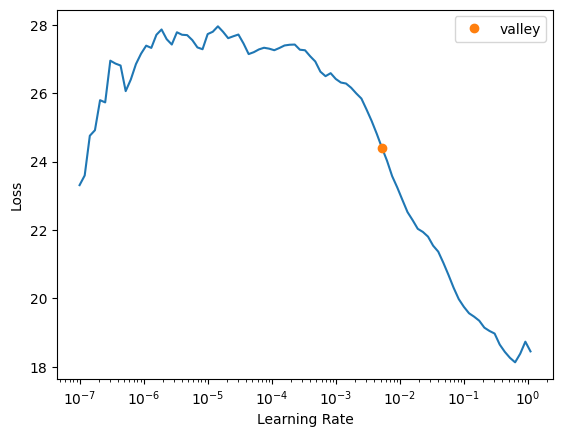

In [18]:
mnist_regression_learner(linear_regression).lr_find()

In general we want to pick the point where the loss is smooth and pointing down, which should hopefully give us a smooth loss decrease during training.

In [19]:
mnist_regression_learner(linear_regression).fit_one_cycle(5, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,3.725286,3.405650,0.222677,00:23
1,3.453069,3.262208,0.234203,00:27
2,3.372854,3.171883,0.216422,00:24
3,3.332236,3.146030,0.225766,00:23
4,3.194652,3.127303,0.218995,00:22


Well, that's not very encouraging, the model seems pretty terrible with less than 25% accuracy, so only slightly better than random choice. Let's review some results.

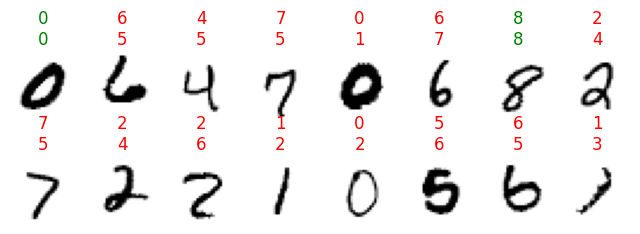

In [20]:
x, y = mnist_loaders.valid.new(shuffle=True, bs=16).one_batch()
y_pred = linear_regression(x).round().int().view(16)

mnist_loaders.show_results((x, y), y_pred.clip(0, 9), max_n=16, ncols=8, figsize=(8, 2.5))

So one of the problems we see here is that our model doesn't know that predictions have to be between `0` and `9`, so every now and then it will return an invalid prediction of `-1` or `10`... the latter has a side effect of `show_results` crashing as well...

We could move the `.clip(0, 9)` to the model, but again, that would introduce regions with zero gradients, so we need a smooth function that would do something similar. Luckily there's a `sigmoid` function, which maps any value to `(0, 1)` range.

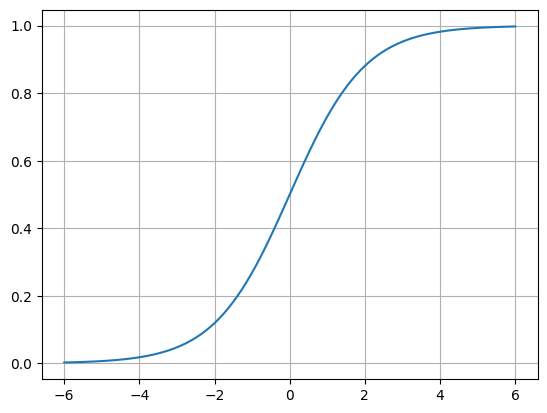

In [21]:
from matplotlib import pyplot as plt

x = torch.linspace(-6, 6, 100)
plt.plot(x, torch.sigmoid(x))
plt.grid(True)
plt.show()

We need `[0, 9]` instead of `(0, 1)`, but that's fairly easy, we can just multiply the output, that's what the `SigmoidRange` layer from `fastai` does.

In [22]:
from fastai.layers import SigmoidRange

linear_regression_sigmoid = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 1),
    SigmoidRange(-0.5, 9.5),
)

Let's train it and see if that helps

In [23]:
mnist_regression_learner(linear_regression_sigmoid).fit_one_cycle(5, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,3.303391,3.149666,0.229617,00:24
1,3.265155,3.157395,0.214105,00:23
2,3.238702,3.060505,0.221066,00:23
3,3.103899,2.999964,0.213525,00:22
4,3.087312,2.987052,0.221142,00:17


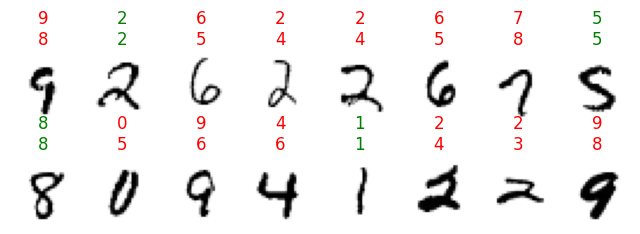

In [24]:
x, y = mnist_loaders.valid.new(shuffle=True, bs=16).one_batch()
y_pred = linear_regression_sigmoid(x).round().int().view(16)

mnist_loaders.show_results((x, y), y_pred, max_n=16, ncols=8, figsize=(8, 2.5))

Well it's still just as terrible as it was, but at least we no longer have to `.clip()`... maybe we just need a more complex model.

In [25]:
linear_deep_regression = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    SigmoidRange(-0.5, 9.5),
)

In [26]:
mnist_regression_learner(linear_deep_regression).fit_one_cycle(5, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,1.049624,1.060519,0.484634,00:13
1,0.804579,0.756718,0.620694,00:13
2,0.613120,0.663689,0.622778,00:16
3,0.467776,0.577142,0.710716,00:13
4,0.375381,0.545314,0.718337,00:16


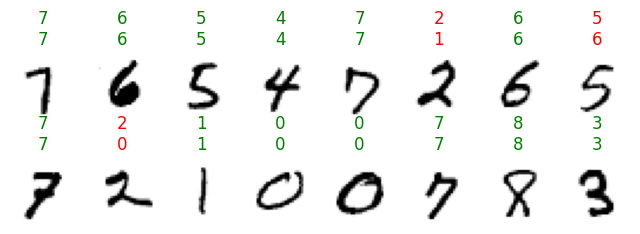

In [27]:
x, y = mnist_loaders.valid.new(shuffle=True, bs=16).one_batch()
y_pred = linear_deep_regression(x).round().int().view(16)

mnist_loaders.show_results((x, y), y_pred, max_n=16, ncols=8, figsize=(8, 2.5))

Now we're getting somewhere! That said, we are still very much under our baseline.

We could probably make the model even more complex, with more neurons and/or layers, but we might be able to do better by changing our approach instead.

## Classification

The problem with our approach so far is that we have been using a regression model for classification. We don't need to estimate the value of the digit, we just want to know which digit it is. Predicting the value makes it harder for the model to figure out similar looking numbers as their values might not be similar at all. For example `1` and `7` can look very similar, but if our model is 50/50 about which it is it will land at `4`, which looks completely different.

What we could do instead is try to predict 10 probabilities, one for each digit, and pick the one with the highest probability. Let's go back to our simplest model and just change the number of outputs to 10.

In [28]:
linear1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 10),
)

We need to also change our training procedure.

First off, we need to change our target, so its shape matches our output. We want the model to learn to predict probabilities and during training we know exactly which digit it is, so we can turn each target digit into a vector with a single 1 (100% probability) and 9 0s for other digits. This is called one-hot encoding.

In [29]:
from torch.nn.functional import one_hot

one_hot(torch.tensor(3), num_classes=10)

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

Let's try training our new model.

In [30]:
from torch.nn.functional import mse_loss, one_hot
from fastai.metrics import accuracy

def mnist_learner(model):
    def loss(pred, target):
        encoded_target = one_hot(target, num_classes=10).float()
        return mse_loss(pred, encoded_target)
    
    return Learner(
        dls=mnist_loaders,
        model=model,
        loss_func=loss,
        metrics=[accuracy],
    )

In [31]:
mnist_learner(linear1).fit_one_cycle(5, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,0.046194,0.046164,0.824500,00:17
1,0.045538,0.045728,0.824000,00:15
2,0.044284,0.044380,0.830000,00:15
3,0.040562,0.040048,0.853200,00:15
4,0.038987,0.038383,0.859400,00:15


With this tiny change we have now beaten our baseline model which had accuracy of around 82% 🏆

Mean-squared error works great for regression, but for classification, where we predict probabilities there's cross-entropy loss, and it looks like:

$\text{CrossEntropyLoss}(x,t) = \text{NLLLoss}(\text{Softmax}(x), t)$

where:

$\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$

$\text{NLLLoss}(x, t) = -log(x_t)$

`Softmax` makes sure that our predictions are in the `[0,1]` range and that they sum up to `1` like real probabilities.

`NLLLoss` is negative log likelihood loss and all it does is just take the `-log()` of our prediction for the target class. That also means that it ignores our predictions for the other classes, as opposed to mean-squared error loss.

Enough math, let's see if changing the loss function helps.

Links:
- https://en.wikipedia.org/wiki/Cross_entropy
- https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
- https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
- https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

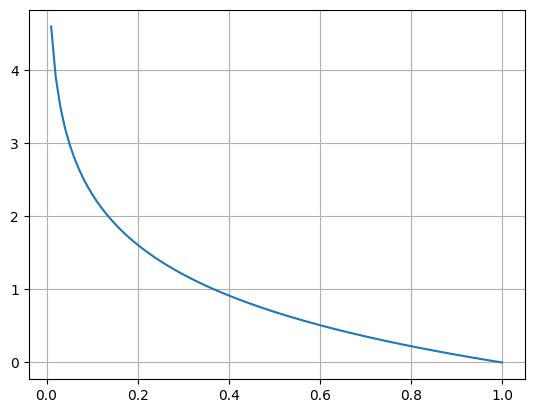

In [32]:
from matplotlib import pyplot as plt

x = torch.linspace(0, 1, 100)
plt.plot(x, -x.log())
plt.grid(True)
plt.show()

In [33]:
from fastai.losses import CrossEntropyLossFlat

def mnist_learner(model):
    return Learner(
        dls=mnist_loaders,
        model=model,
        loss_func=CrossEntropyLossFlat(),
        metrics=[accuracy],
    )

In [34]:
linear1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 10),
)

mnist_learner(linear1).fit_one_cycle(5, 0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.582045,0.694551,0.852200,00:16
1,0.589605,0.734203,0.856100,00:14
2,0.483319,0.479885,0.902200,00:16
3,0.325210,0.335756,0.917400,00:16
4,0.236795,0.292588,0.927100,00:18


Another step in the right direction 🏆

Because we have a single weight for each pixel for each digit, we can view the learned weights to see what our network looks for in each digit.

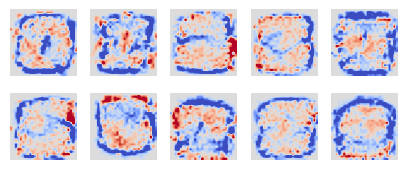

In [35]:
show_images(linear1[1].weight.view(10, 1, 28, 28), ncols=5, vrange=0.2)

Warm colors represent positive weights and cold negative ones. This means that the network expects lines to be where the red spots are and doesn't want lines in blue spots.

You can clearly see blue outlines of numbers and some red spots, which are characteristic to each digit. For example it seems that when there's a line in the top right that does not go down, that's a good predictor of a `5`.

Let's see where we can get with a deeper network.

In [36]:
linear2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

mnist_learner(linear2).fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.203209,0.175742,0.943700,00:21
1,0.141420,0.138317,0.959100,00:14
2,0.080144,0.103664,0.971000,00:14
3,0.043771,0.077947,0.978500,00:24
4,0.021813,0.073896,0.979600,00:23


Just 2% error rate, another huge jump in accuracy. Now that we are getting very close to 100%, let's review cases where the model has problems. `fastai` offers a couple helpers for intepreting the results. We can start with showing the samples that we are most incorrect about, that have the highest losses.

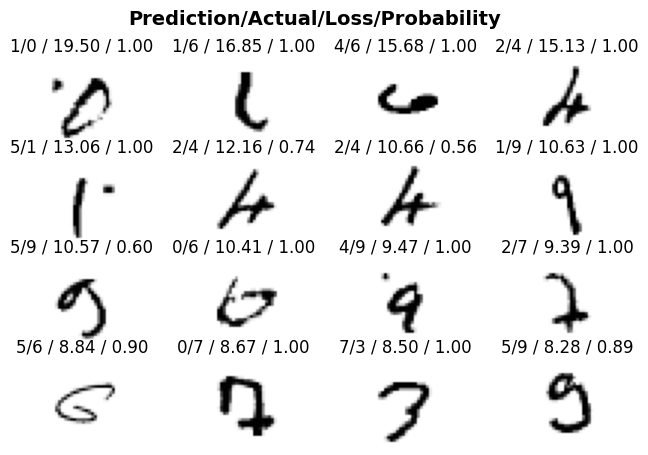

In [37]:
from fastai.interpret import Interpretation

Interpretation.from_learner(mnist_learner(linear2)).plot_top_losses(k=16, ncols=4, figsize=(8, 5))

As you can see we are very much in the MNIST hard mode. Some of these a human would have problems with as well.

We can also plot a confusion matrix, which shows how many digits we are mislabeling and how. On the diagonal we see correct labels, everywhere else there are errors.

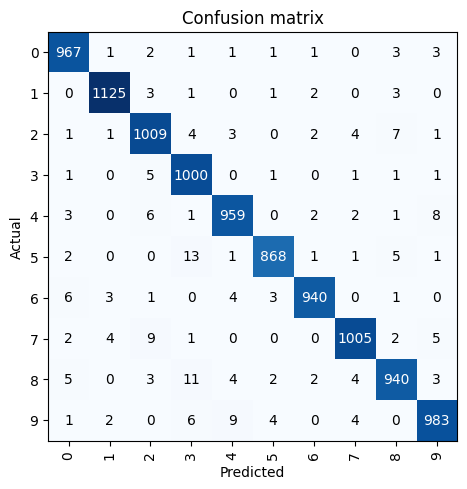

In [38]:
from fastai.interpret import ClassificationInterpretation

ClassificationInterpretation.from_learner(mnist_learner(linear2)).plot_confusion_matrix()

Again, we can try brute-forcing the problem and just adding more complexity to the network.

In [39]:
linear3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

mnist_learner(linear3).fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.205686,0.184173,0.942600,00:24
1,0.163543,0.149217,0.955900,00:22
2,0.097552,0.107797,0.969700,00:22
3,0.052844,0.074241,0.979800,00:23
4,0.019592,0.072252,0.981900,00:20


However, it seems that we need to change our approach again if we want to solve these last 2%.

## Convolutions

There are a couple problems with our previous models:

1. The model will only work with 28x28 images
2. The number of parameters is proportional to the number of pixels

`fastai` `Learner` has a `summary()` method to review inputs, outputs and numbers of parameters of each layer

In [46]:
mnist_learner(linear2).summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 784            
Flatten                                                        
____________________________________________________________________________
                     64 x 128            
Linear                                    100480     True      
ReLU                                                           
____________________________________________________________________________
                     64 x 10             
Linear                                    1290       True      
____________________________________________________________________________

Total params: 101,770
Total trainable params: 101,770
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f94f5ff20e0>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCallback
  - CastToTensor
  - Recorder
  - ProgressCallback

Even though we have a relatively simple model and just 28x28px images, we've already gathered over 100k parameters. This would clearly not scale to normal images or photos, where we might want to use 512x512px images with 3 color channels.

In [64]:
format(param_count(
    nn.Sequential(
        nn.Flatten(),
        nn.Linear(3 * 512 * 512, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
    )
), ",")

'100,664,714'

100M parameters even without increasing the number of neurons in the hidden layer. We need a different way to process images of arbitrary size. 

Luckily people have been processing images for decades and so we can draw inspiration from that. Common image filters such as blur or sharpen use convolution under the hood. Filters like these calculate the color of the output pixel by multiplying the corresponding input pixel and its surroundings by a matrix and summing the values up. This matrix is called a convolution kernel. 

Let's visualize how that works with a simple blur kernel, which just averages out surrounding pixels.

In [736]:
import ipywidgets as widgets
from torch.nn.functional import conv2d
from torchvision.transforms import ToTensor
from IPython.display import display
from matplotlib import pyplot as plt

def interactive_conv2d(image, kernel):
    image_height, image_width = image.shape[1:]
    
    def render(padding=0, stride=1, step=1):
        output, = conv2d(
            image.view(1, *image.shape), 
            kernel.view(1, 1, *kernel.shape).float(),
            padding=padding,
            stride=stride,
        )
        output_height, output_width = output.shape[1:]
        step_slider.max = output.numel()
        
        step = min(step, step_slider.max)
        index = step - 1
        
        fig, (image_ax, output_ax) = plt.subplots(1, 2)
        
        image_ax.set_xlim(-padding, image_width + padding)
        image_ax.set_ylim(image_height + padding, -padding)
        image_ax.set_facecolor("black")
        
        image_ax.imshow(
            image.permute(1, 2, 0), 
            cmap="gray", 
            extent=(0, image_width, image_height, 0),
            vmin=0,
            vmax=1,
        )
        image_ax.add_patch(plt.Rectangle(
            xy=(
                (index % output_width) * stride - padding,
                (index // output_width) * stride - padding,
            ),
            width=kernel.shape[1],
            height=kernel.shape[0],
            fill=False,
            color="red",
        ))
        image_ax.set_title("input")
        
        output_ax.imshow(
            output.permute(1, 2, 0),
            cmap="gray",
            extent=(0, output_width, output_height, 0),
            vmin=0,
            vmax=1,
        )
        output_ax.add_patch(plt.Rectangle(
            xy=(index % output_width, index // output_width),
            width=1,
            height=1,
            fill=False,
            color="red",
        ))
        output_ax.set_title("output")

    padding_slider = widgets.IntSlider(min=0, max=2, value=0, description="padding")
    stride_slider = widgets.IntSlider(min=1, max=3, value=1, description="stride")
    step_slider = widgets.IntSlider(min=1, max=1, value=1, description="step")
    
    display(widgets.HBox([
        widgets.VBox([padding_slider, stride_slider]),
        step_slider,
    ]))
    
    interactive_output = widgets.interactive_output(render, dict(
        padding=padding_slider,
        stride=stride_slider,
        step=step_slider,
    ))
    interactive_output.layout.height = '350px'
    
    display(interactive_output)

In [750]:
kernel = torch.tensor([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
]) / 9

In [751]:
interactive_conv2d(
    image=ToTensor()(PILImageBW.create("./images/codequest_tiny.png")),
    kernel=kernel,
)

Output(layout=Layout(height='350px'))

In [837]:
from torch.nn.functional import conv2d

def simple_conv2d(image, kernel):
    return torch.cat([
        conv2d(
            channel.view(1, 1, *channel.shape), 
            kernel.view(1, 1, *kernel.shape).float(),
        )[0]
        for channel in image
    ]).clip(0, 1)

Now that we know how convolution works, let's experiment with a few simple kernels on a picture of a [giant rubber duck](https://thebigduck.us/)... beacause why not 😉

Links:
- https://thebigduck.us/
- https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html?highlight=totensor#torchvision.transforms.ToTensor

torch.Size([3, 259, 400])

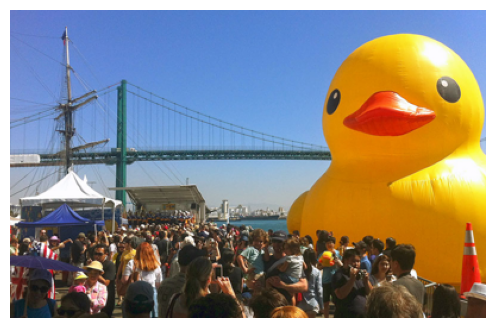

In [822]:
from fastai.vision.all import PILImage
from torchvision.transforms import ToTensor

big_duck = ToTensor()(PILImage.create("./images/big-duck.jpg").to_thumb(400))
show_image(big_duck, figsize=(8, 4))
big_duck.shape

First off, let's generalize our blur to any kernel size and see how that works.

<AxesSubplot: >

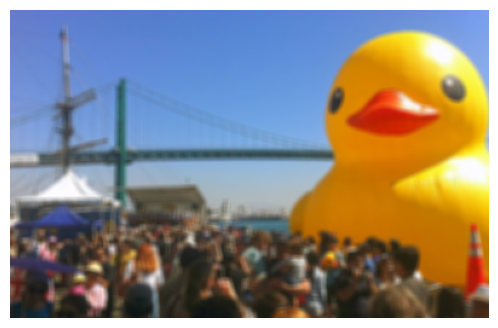

In [823]:
def blur_kernel(size=3):
    return torch.ones(size, size) / size / size

show_image(simple_conv2d(big_duck, blur_kernel(5)), figsize=(8, 4))

Sharpening is a bit more complicated, we need to boost the value for the center pixel and then subtract the blur. A kernel that just returns the original pixel and ignores the surroundings is called an identity kernel and we'll use it to boost the center pixel.

<AxesSubplot: >

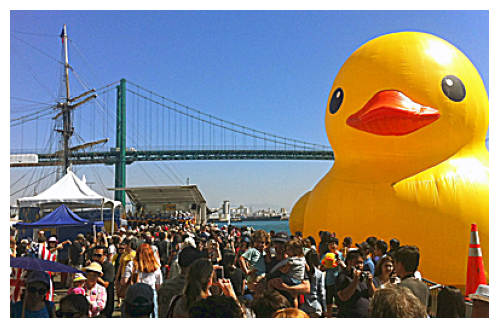

In [824]:
def identity_kernel(size=3):
    identity = torch.zeros(size, size)
    identity[size // 2, size // 2] = 1
    return identity

def sharpen_kernel(size=3):
    return 2 * identity_kernel(size) - blur_kernel(size)

show_image(simple_conv2d(big_duck, sharpen_kernel(5)), figsize=(8, 4))

Now this is fun and all, but how does that fit into neural networks? Well, we can also do feature detection with convolutions, for example these kernels detect horizontal and vertical edges respectively.

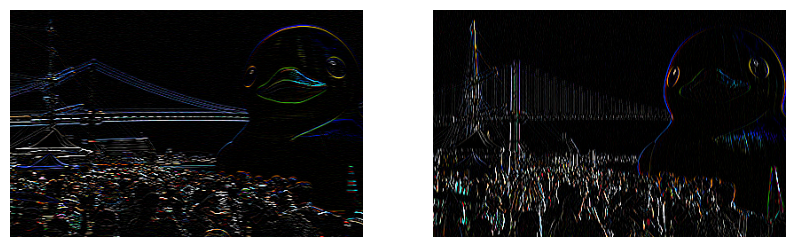

In [854]:
horizontal_detector = torch.tensor([
    [-1, -1, -1],
    [+2, +2, +2],
    [-1, -1, -1],
])
vertical_detector = torch.tensor([
    [-1, +2, -1],
    [-1, +2, -1],
    [-1, +2, -1],
])

show_images([
    simple_conv2d(big_duck, horizontal_detector),
    simple_conv2d(big_duck, vertical_detector),
], figsize=(10, 5))

There's many many more such kernels that people have already figured out, but what we can do with neural networks is let gradient descent create kernels for us. Instead of using a linear/dense layer we can use a convolutional layer, which uses kernel weights as parameters.

In [840]:
conv1 = nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=2),
    nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=2),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 10, 2),
    nn.Flatten(),
)

mnist_learner(conv1).fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.161055,0.153532,0.951600,00:10
1,0.091740,0.078821,0.974700,00:10
2,0.068517,0.061987,0.980500,00:10
3,0.038473,0.049465,0.984900,00:10
4,0.017857,0.046081,0.986300,00:10


In [42]:
param_count(linear2), param_count(conv1)

(101770, 7178)

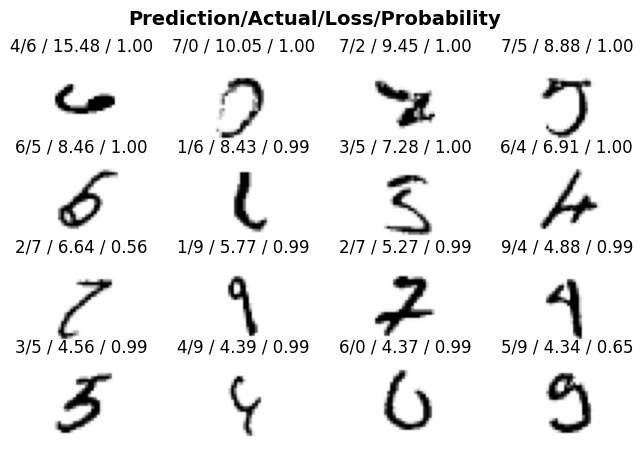

In [45]:
Interpretation.from_learner(mnist_learner(conv1)).plot_top_losses(k=16, ncols=4, figsize=(8, 5))